# Utilização da `BibMon` na detecção de eventos indesejados presentes no `3W Dataset`:

O presente notebook surgiu no `HACKTHON` Petrobras 2024' e demonstra como utilizar o software BibMon para detectar de eventos indesejáveis através de sensores marítimos em poços de petróleo.

> Isso é `EnergIA`! :)

Integrantes:

- Laura Magalhães
- Igor Infingardi
- Juliana Hansen
- Helena Lannes


A ideia desse notebook é estabelecer uma métrica de quais arquivos são melhores para nossas análises, assim, avaliaremos os arquivos de um determinado poço e evento e compararemos seus resultados.
Inicialmente escolhemos o poço 14 no evento 3, por ter muitos arquivos.

In [1]:
import sys
import os
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import missingno

sys.path.append('3W')
sys.path.append('BibMon')

In [2]:
def load_all_data_by_event_and_well(event, well):
    PATH = os.path.join('..', '..', '..', '3W', 'dataset', str(event)) 
    
    # Inicializar a lista de arquivos
    files = []
    
    if os.path.exists(PATH):
        files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]
    else:
        print(f"O caminho {PATH} não existe.")
    
    dfs = {}
    
    if files:  # Verifica se a lista de arquivos não está vazia
        for file in files:
            file_path = os.path.join(PATH, file)
            try:
                fromWell = file.startswith(f"WELL-{well}")
                
                if file.endswith('.csv') and fromWell:
                    # Tentar ler o arquivo CSV com a codificação padrão
                    dfs[file[:-4]] = pd.read_csv(file_path, index_col=0, parse_dates=True).rename_axis(None)
                elif file.endswith('.parquet') and fromWell:
                    # Ler o arquivo Parquet
                    dfs[file[:-8]] = pd.read_parquet(file_path)  # Remover o sufixo '.parquet'
                elif fromWell:
                    print(f"Formato de arquivo desconhecido para {file}.")
            except Exception as e:
                print(f"Erro ao ler {file}: {e}")
    
        print('Data read!\nNumber of instances: ', len(dfs))
    else:
        print("Nenhum arquivo encontrado.")

    return dfs

well = '00001'
dataEvent = load_all_data_by_event_and_well(1, well)

Data read!
Number of instances:  1


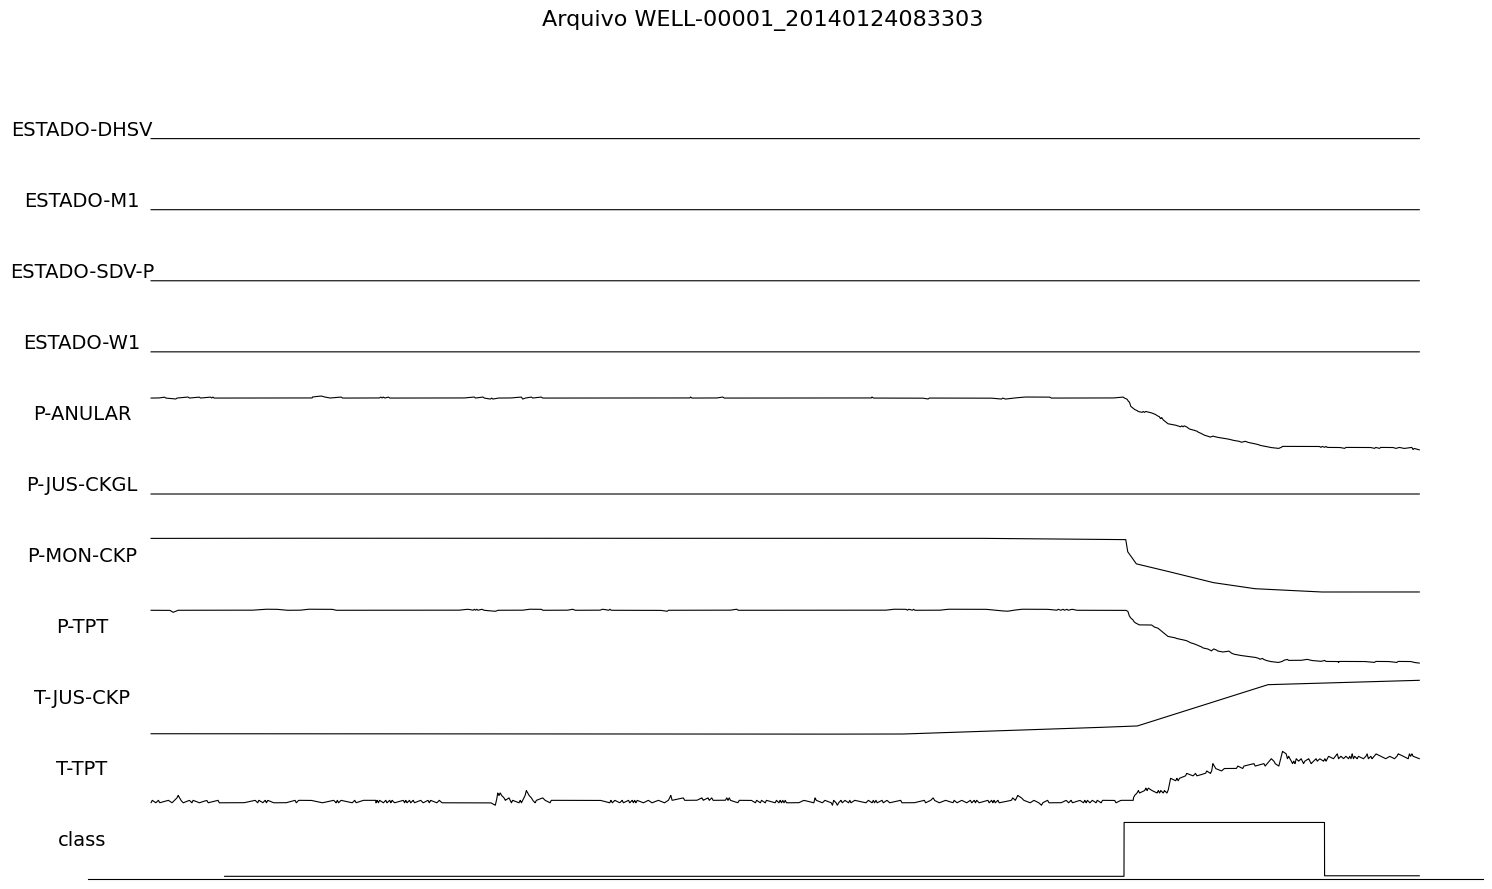

In [3]:
def getWellDataAndPlot(data, color, title):
    # archivesKeys = data.keys()
    # filteredByWellData = pd.concat([data[key] for key in archivesKeys]) #Data filtrada para o poço
    
    filteredByWellData = data.apply(pd.to_numeric, errors='coerce')

    # Remover colunas que são todas NaN ou que contêm apenas zeros
    filteredByWellData = filteredByWellData.dropna(axis=1, how='all')  # Remove colunas que são todas NaN
    filteredByWellData = filteredByWellData.loc[:, (filteredByWellData != 0).any(axis=0)]  # Remove colunas que são todas 0
    # Filtra colunas onde todos os valores são iguais (remove colunas com todos os valores iguais)
    # filteredByWellData = filteredByWellData.loc[:, filteredByWellData.nunique() > 1]

    tags = list(filteredByWellData.keys())
    # notWantedTags = ['ESTADO-M1', 'ESTADO-SDV-P', 'ESTADO-W1', 'P-PDG', 'QGL']
    # tags = [key for key in tags if key not in notWantedTags]

    fig, ax = plt.subplots(len(tags), 1, figsize=(18, 10),sharex=True)
    fig.suptitle(f"Arquivo {title}", fontsize=16)
    
    for i, tag in enumerate(tags):
        tagData = filteredByWellData[tag].values

        # if tag == 'class':
        #     tagData = tagData * 10000
        # else:
        #     tagData = tagData / 10000
        # print(tagData)
        ax[i].plot(tagData, c=color, linewidth=0.8)
        ax[i].set_ylabel(tag, rotation=0, fontsize=14)
        ax[i].set_yticks([])
    
        # Limpar bordas desnecessárias
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
    
        if i < len(tags)-1:  # Oculta os eixos X de todos, exceto o último gráfico
            ax[i].set_xticks([])
            ax[i].spines["bottom"].set_visible(False)
            ax[i].xaxis.set_ticks_position('none')
        else:
            # Rotaciona rótulos no último gráfico para melhor legibilidade
            for label in ax[i].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')
    return filteredByWellData
   
for fileName, file in dataEvent.items():
    dataEvent[fileName] = getWellDataAndPlot(file, 'k', fileName)

In [4]:
print(dataEvent)


{'WELL-00001_20140124083303':                      ESTADO-DHSV  ESTADO-M1  ESTADO-SDV-P  ESTADO-W1  \
timestamp                                                              
2014-01-24 08:33:03          1.0        1.0           1.0        1.0   
2014-01-24 08:33:04          1.0        1.0           1.0        1.0   
2014-01-24 08:33:05          1.0        1.0           1.0        1.0   
2014-01-24 08:33:06          1.0        1.0           1.0        1.0   
2014-01-24 08:33:07          1.0        1.0           1.0        1.0   
...                          ...        ...           ...        ...   
2014-01-25 01:47:26          1.0        1.0           1.0        1.0   
2014-01-25 01:47:27          1.0        1.0           1.0        1.0   
2014-01-25 01:47:28          1.0        1.0           1.0        1.0   
2014-01-25 01:47:29          1.0        1.0           1.0        1.0   
2014-01-25 01:47:30          1.0        1.0           1.0        1.0   

                       P-ANULAR  

In [5]:
firstFile = list(dataEvent.keys())[0]
dataFault = dataEvent[firstFile]
dataFault.index = pd.to_datetime(dataFault.index)
dataFault = dataFault.sort_index()


In [6]:
index_above_100 = dataFault[dataFault['class'] > 1].index[0]

fault_start = index_above_100
fault_end = dataFault.index[-1]  # Último valor de dataFault

# Mostra os resultados
print("Início da falha onde primeiro índice class é maior que 100:", fault_start)
print("Fim da falha:", fault_end)


Início da falha onde primeiro índice class é maior que 100: 2014-01-24 21:46:39
Fim da falha: 2014-01-25 01:47:30


In [7]:
fault_start_position = dataFault.index.get_loc(fault_start)

# Calcular o número de dados entre o início e end_validation
n_train = fault_start_position - 1  # +1 para incluir o índice de end_validation

# Calcular 70% dos dados até end_validation
end_train_position = int(0.5 * n_train)

# Definir o índice de end_validation um pouco antes do início da falta
end_validation_position = int(0.9 * fault_start_position)
end_validation = dataFault.index[end_validation_position]

# Definir os índices start_train, end_train, end_validation e end_test
start_train = dataFault.index[0]
end_train = dataFault.index[end_train_position]  # Agora baseado em 85% até end_validation
end_test = dataFault.index[-1]

# Exibir os resultados
print(f"Início do treino: {start_train}")
print(f"Fim do treino (85% até end_validation): {end_train}")
print(f"Fim da validação: {end_validation}")
print(f"Fim do teste: {end_test}")


Início do treino: 2014-01-24 08:33:03
Fim do treino (85% até end_validation): 2014-01-24 15:09:50
Fim da validação: 2014-01-24 20:27:17
Fim do teste: 2014-01-25 01:47:30


In [8]:
import bibmon 

(X_train, X_validation, 
 X_test, Y_train, 
 Y_validation, Y_test) = bibmon.train_val_test_split(dataFault, 
                                                     start_train = start_train, #Início da base de dados
                                                     end_train = end_train, 
                                                     end_validation = end_validation, #Horas antes da falta
                                                     end_test = end_test, #Fim da base de dados 
                                                     tags_Y = 'P-MON-CKP') #Essa variável será usada para análise da regressão do modelo


In [9]:
from sklearn.ensemble import RandomForestRegressor  
reg = RandomForestRegressor(n_jobs=-1, random_state=1)

model = bibmon.sklearnRegressor(reg) 

In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

mtr = [r2_score, mean_absolute_error]

CPU times: total: 8.25 s
Wall time: 3.34 s


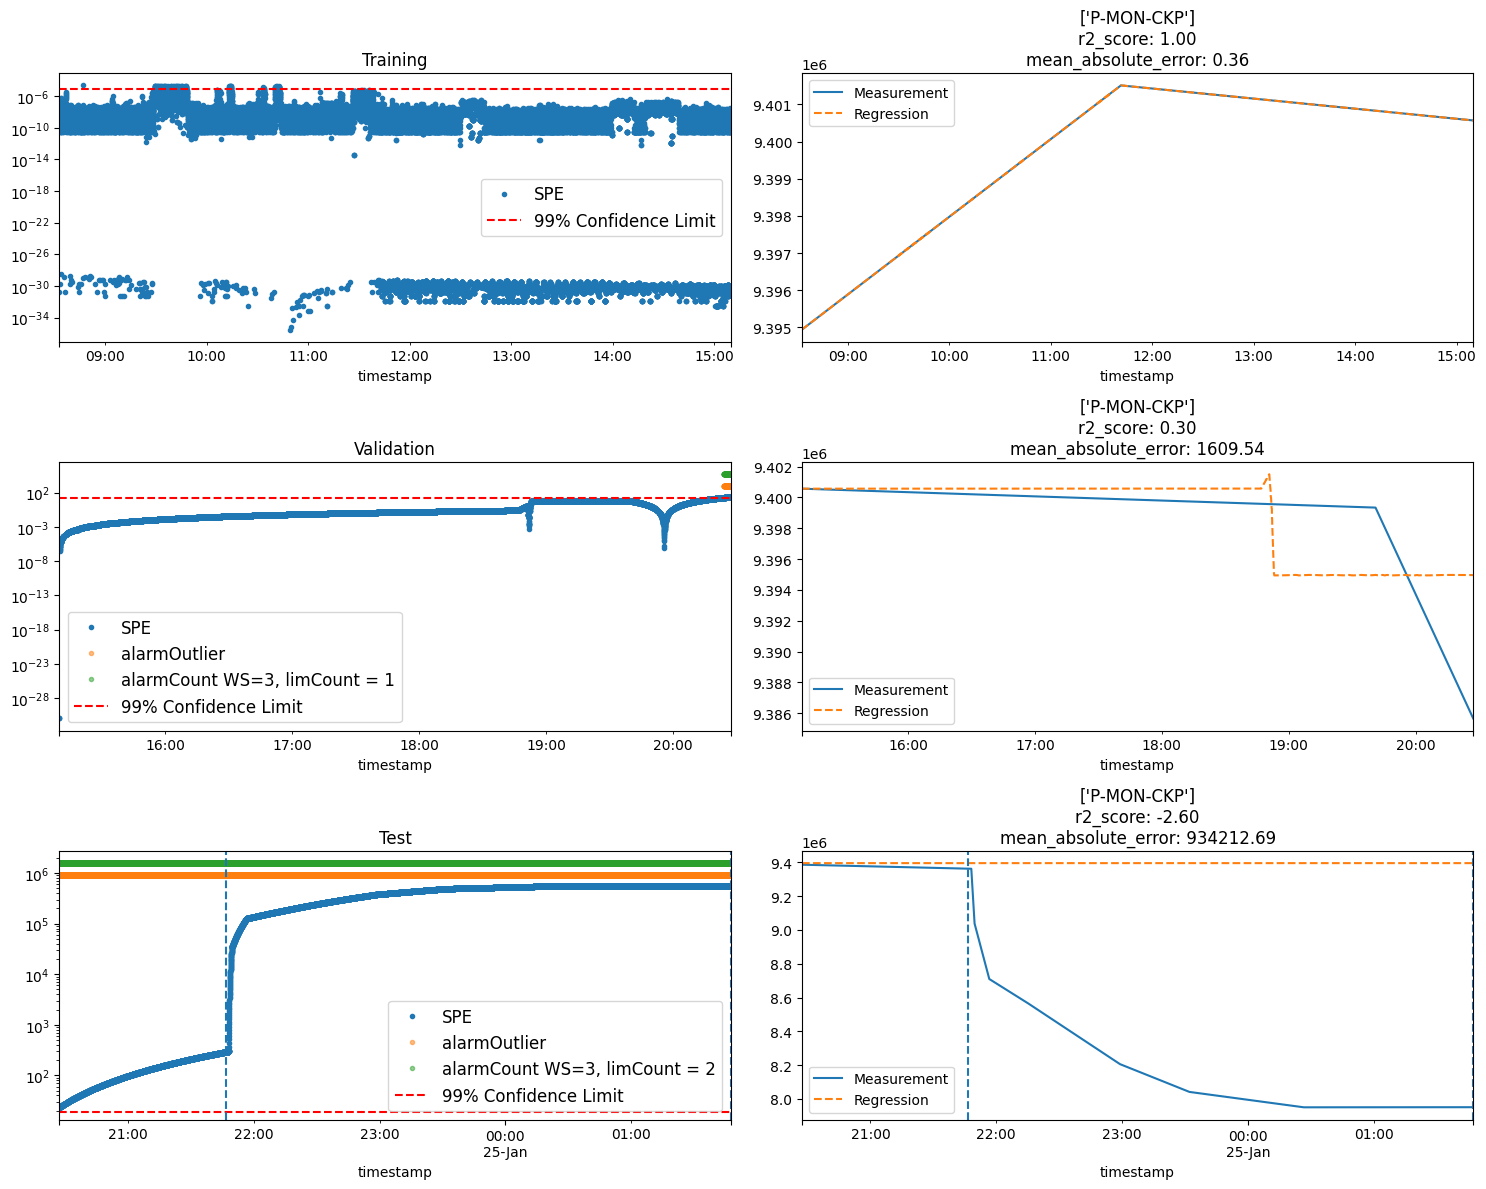

In [11]:
%%time

bibmon.complete_analysis(model, X_train, X_validation, X_test, 
                         Y_train, Y_validation, Y_test,                    
                         metrics = mtr, count_window_size = 3, count_limit = 2,
                         fault_start = fault_start,
                         fault_end = fault_end)                       

In [38]:
def align_dfs_by_rows (df1, df2):
    """
    Aligns DataFrames by rows.

    Parameters
    ----------
    df1, df2: pandas.DataFrame
        Original data.
    Returns
    ----------                
    new_df1, new_df2: pandas.DataFrame
        Processed data.
    """
    
    new_df1 = df1.loc[df1.index.isin(df2.index)]
    new_df2 = df2.loc[df2.index.isin(df1.index)]

    return new_df1, new_df2

def compare_variables_for_regression (data, start_train, end_train, 
                          end_validation, end_test, 
                          tags,
                          model,
                          metrics, count_window_size, count_limit,
                          fault_start,
                          fault_end,
                          tags_X = None,
                          f_pp_train = ['remove_empty_variables',
                                     'ffill_nan',
                                     'remove_frozen_variables',
                                     'normalize'],
                          a_pp_train = None,
                          f_pp_test = ['replace_nan_with_values',
                                    'normalize'],
                          a_pp_test = None,):

    return_tables = []
    
    train_metrics = {}     
    validation_metrics = {}        
    test_metrics = {}        

    detection_alarms = {}
    false_detection_rates = {}
    false_alarm_rates = {}

               
    train_data = data.loc[start_train:end_train]
    validation_data = data.loc[end_train:end_validation].iloc[1:,:]
    test_data = data.loc[end_validation:end_test].iloc[1:,:]

    errorTags = []
    for tag_Y in tags:
        try:
            if not isinstance(tag_Y, list): tag_Y = [tag_Y]
    
            # train_data_Y = train_data.loc[:,tag_Y]
            # validation_data_Y = validation_data.loc[:,tag_Y]
            # test_data_Y = test_data.loc[:,tag_Y]
    
            # if tags_X is not None:
    
            #     if not isinstance(tags_X, list): tags_X = [tags_X]
                
            #     train_data_X = train_data.loc[:,tags_X]
            #     validation_data_X = validation_data.loc[:,tags_X]
            #     test_data_X = test_data.loc[:,tags_X]
    
            # else:
    
            #     dif = train_data.columns.difference(train_data_Y.columns)
            #     train_data_X = train_data[dif]
            #     validation_data_X = validation_data[dif]
            #     test_data_X = test_data[dif]
    
            (X_train, X_validation, 
             X_test, Y_train, 
             Y_validation, Y_test) = bibmon.train_val_test_split(data, 
                                                                 start_train = start_train, #Início da base de dados
                                                                 end_train = end_train, 
                                                                 end_validation = end_validation, #Horas antes da falta
                                                                 end_test = end_test, #Fim da base de dados 
                                                                 tags_Y = tag_Y) #Essa variável será usada para análise da regressão do modelo
    
            ######## TRAINING ########
            lim_conf = 0.99
            # f_pp_train = ['remove_empty_variables',
            #              'ffill_nan',
            #              'remove_frozen_variables',
            #              'normalize'],
            # a_pp_train = [],
            # f_pp_test = ['replace_nan_with_values',
            #             'normalize'],
            # a_pp_test = [],
    
            model.fit(X_train, Y_train, 
                      f_pp = f_pp_train,
                      a_pp = a_pp_train,
                      f_pp_test = f_pp_test,
                      a_pp_test = a_pp_test,
                      lim_conf = lim_conf,
                      redefine_limit = False)
            
            if metrics is not None:
                if model.has_Y:
                    true = model.Y_train_orig
                    pred = model.Y_train_pred_orig
                else:
                    if X_pred_to_plot is not None:
                        true = model.X_train_orig[X_pred_to_plot]
                        pred = model.X_train_pred_orig[X_pred_to_plot]                
                for mr in metrics:
                    true, pred = align_dfs_by_rows(true.dropna(), pred)
                    train_metrics[tag_Y[0] +': '+mr.__name__] = mr(true, pred)
                            
            ######## VALIDATION ########
    
            model.predict(X_validation, Y_validation, 
                          count_window_size = count_window_size, 
                          redefine_limit = True)        
    
            if metrics is not None:
                if model.has_Y:
                    true = model.Y_test_orig
                    pred = model.Y_test_pred_orig
                else:
                    if X_pred_to_plot is not None:
                        true = model.X_test_orig[X_pred_to_plot]
                        pred = model.X_test_pred_orig[X_pred_to_plot]                
                for mr in metrics:
                    true, pred = align_dfs_by_rows(true.dropna(), pred)
                    validation_metrics[tag_Y[0] +': '+mr.__name__] = mr(true, pred)
    
    
            ######## TEST ########
                    
            model.predict(X_test, Y_test, 
                          count_window_size = count_window_size, 
                          count_limit = count_limit,
                          redefine_limit = False)
    
            if metrics is not None:
                if model.has_Y:
                    true = model.Y_test_orig
                    pred = model.Y_test_pred_orig
                else:
                    if X_pred_to_plot is not None:
                        true = model.X_test_orig[X_pred_to_plot]
                        pred = model.X_test_pred_orig[X_pred_to_plot]                
                for mr in metrics:
                    true, pred = align_dfs_by_rows(true.dropna(), pred)
                    test_metrics[tag_Y[0] +': '+mr.__name__] = mr(true, pred)
                    
        except ValueError as err:
            errorTags.append(tag_Y[0])
            print("Erro com a tag:" + tag_Y[0])
            
    tags = [key for key in tags if key not in errorTags]

    return_tables = []
        
    # PREDICTION

    if metrics is not None:

        prediction_table = pd.DataFrame([train_metrics, validation_metrics,
                                         test_metrics], 
                                        index = ['Train',
                                                 'Validation',
                                                 'Test']).T
                                                            
        tags_names = [tags[i] for i in range(len(tags))]
        metrics_names = [metrics[i].__name__ for i in range(len(metrics))]
        
        iterables = [tags_names, metrics_names]

        index = pd.MultiIndex.from_product(iterables, 
                                           names = ['Tags', 'Metrics'])
        
       
        message = ("The MultiIndex table is not of the right size. "+
                   "This could happen when two tags have the same name.")
        
        try:
            prediction_table.index = index
        except ValueError as err:
            raise ValueError(message) from err
            
        
        return_tables.append(prediction_table.swaplevel().sort_index(axis=0))

    return return_tables
            
###############################################################################


In [39]:
dataFault = dataFault.dropna(axis=1, how='any')

allTags = list(dataFault.keys())
notWantedTags = ['class']
allTags = [key for key in allTags if key not in notWantedTags]
# 
print(allTags)

# allTags = ['P-ANULAR', 'P-JUS-CKGL', 'P-MON-CKP', 'P-TPT', 'T-JUS-CKP', 'T-TPT']


['ESTADO-DHSV', 'ESTADO-M1', 'ESTADO-SDV-P', 'ESTADO-W1', 'P-ANULAR', 'P-JUS-CKGL', 'P-MON-CKP', 'P-TPT', 'T-JUS-CKP', 'T-TPT']


In [42]:


tab_pred = compare_variables_for_regression(dataFault, 
                                         start_train=start_train,  # Início da base de dados
                                         end_train=end_train, 
                                         end_validation=end_validation,  # Horas antes da falta
                                         end_test=end_test,  # Fim da base de dados 
                                         tags= allTags,  # Essa variável será usada para análise da regressão do modelo                   
                                         model=model,  # Passando 'model' como keyword argument
                                         metrics=mtr, 
                                         count_window_size=3, 
                                         count_limit=2,
                                         fault_start=fault_start,
                                         fault_end=fault_end)


Erro com a tag:ESTADO-DHSV
Erro com a tag:ESTADO-M1
Erro com a tag:ESTADO-SDV-P
Erro com a tag:ESTADO-W1


In [43]:
tab_pred[0]

Train    Validation           Test
Metrics             Tags                                              
mean_absolute_error P-ANULAR    10.087478   3410.818217  586267.059631
                    P-JUS-CKGL   0.000000      0.000000       0.000000
                    P-MON-CKP    0.360924   1609.543223  934212.687620
                    P-TPT       11.877279  10444.273562  587448.729777
                    T-JUS-CKP    0.000024      0.064324       2.569955
                    T-TPT        0.000161      0.020641       0.414209
r2_score            P-ANULAR     0.999904     -0.939614      -2.078494
                    P-JUS-CKGL   1.000000      1.000000       1.000000
                    P-MON-CKP    1.000000      0.301416      -2.600367
                    P-TPT        0.999873     -1.493480      -1.977755
                    T-JUS-CKP    0.998172     -0.078327      -2.450005
                    T-TPT        0.999738     -0.585765      -1.957187